<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center>
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center>
    <font size="4">Computer Vision 1 University of Amsterdam</font>
</center>
<center>
    <font size="4">Due 23:59PM, 24th October, 2025 (Amsterdam time)</font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID: 14633485 \
Student1 Name: David van Batenburg

Student2 ID: 16195965\
Student2 Name: Samuele Punzo

Student3 ID: 16334523 \
Student3 Name: Edoardo Vergnano

Student4 ID: 16217632 \
Student4 Name: Seyedeh Zahra Ahmadi

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup.

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **PDF format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

In [11]:
import faiss
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
import os

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

In [6]:
def extract_features(image_rgb, method):

    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    extractor = None

    if method == "sift":
        extractor = cv2.SIFT_create()
    elif method == "orb":
        extractor = cv2.ORB_create(nfeatures=500, edgeThreshold=5, patchSize=5, nlevels=4)
    else:
        raise ValueError("Method has to be either sift or orb")

    keypoints, descriptors = extractor.detectAndCompute(gray, None)

    return keypoints, descriptors

def denormalize_image(image, scale=4, mean=0.5, std=0.5):

    denorm_image = (image * std) + mean
    denorm_image = torch.clamp(denorm_image, 0, 1)

    denorm_image = (denorm_image.numpy() * 255).astype(np.uint8)
    denorm_image = cv2.resize(denorm_image, (denorm_image.shape[1]*scale, denorm_image.shape[0]*scale))

    return denorm_image

def keypoints_and_descriptors(dataset, method="SIFT", scale=4):
    keypoints = []
    descriptors = []

    for i in range(dataset.shape[0]):
        image = dataset[i]
        # Denormalize image for feature extraction
        denorm_img = denormalize_image(image, scale)
        keypoint, descs = extract_features(denorm_img, method=method)
        keypoints.append(keypoint)
        descriptors.append(descs)

    return keypoints, descriptors

# Detect SIFT and ORB keypoints for images in the entire training set
train_kp_sift, train_dp_sift = keypoints_and_descriptors(train_images, "sift")
train_kp_orb, train_dp_orb = keypoints_and_descriptors(train_images, "orb")



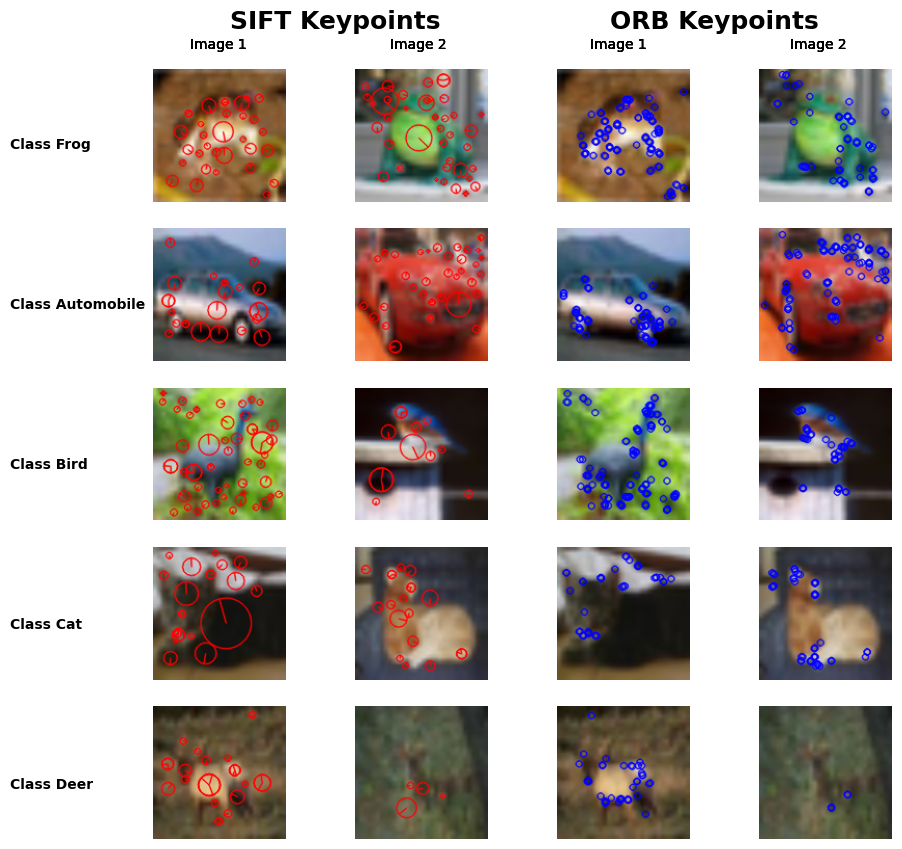

In [30]:
# Visualizing keypoints for two images of each class

# Indices of first two images of each class
image_indices = []
for i in range(5):
    class_i = (train_labels == i).tolist()
    indices = [idx for idx, mask in enumerate(class_i) if mask]
    image_indices.append(indices[:2])

fig, axes = plt.subplots(5, 4, figsize=(10, 10))

for idx, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
    label_indices = image_indices[idx]
    fig.text(0, 0.8-(0.16*idx), f"Class {label}", fontweight="bold")
    for j in range(2):
        fig.text(0.18 + j*0.2, 0.9, f"Image {j+1}")
        fig.text(0.58 + j*0.2, 0.9, f"Image {j+1}")
        image_index = label_indices[j]
        img = denormalize_image(train_images[image_index])

        img_sift = cv2.drawKeypoints(img, train_kp_sift[image_index], color=(255, 0, 0),
                                     outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        img_orb = cv2.drawKeypoints(img, train_kp_orb[image_index], color=(0, 0, 255),
                                      outImage=None, flags=0)

        axes[idx, j].imshow(img_sift)
        axes[idx, j].axis("off")

        axes[idx, j+2].imshow(img_orb)
        axes[idx, j+2].axis("off")

fig.text(0.22, 0.92, "SIFT Keypoints", fontweight="bold", fontsize=18)
fig.text(0.6, 0.92, "ORB Keypoints", fontweight="bold", fontsize=18)

plt.savefig(os.path.join("results", "keypoints_comparison.png"))

plt.show()

<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

In [31]:
def get_subdata(frac, images, labels):

    n = images.shape[0]
    frac_n = int(frac * n)

    new_images = images[:frac_n]
    new_labels = labels[:frac_n]

    return new_images, new_labels

def compute_kmeans(descriptors, n_clusters=num_of_visual_words):

    dim = descriptors.shape[1]
    kmeans = faiss.Kmeans(d=dim, k=n_clusters, niter=200)
    kmeans.train(descriptors)

    return kmeans

def compute_pca(data, new_dim=2):

    pca = PCA(n_components=new_dim)
    pca.fit(data)

    return pca

In [32]:
def visualize_clusters(centers, data, assignments, method, frac, num_clusters=10):
    """
    Plots the scatter plot containing the first 10 clusters for the data with the corresponding centers
    """

    plt.figure(figsize=(10, 7))

    for i in range(num_clusters):
        center = centers[i]
        points = data[assignments == i]

        plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i+1}")
        plt.scatter(center[0], center[1], marker="x", color="black", s=75, linewidths=3)

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"First {num_clusters} clusters using {int(frac*100)}% of data and {method} ")
    plt.legend()

    plt.savefig(os.path.join("results", "clusters", f"clusters_{int(frac*100)}perc_{method}.png"))
    
    plt.show()

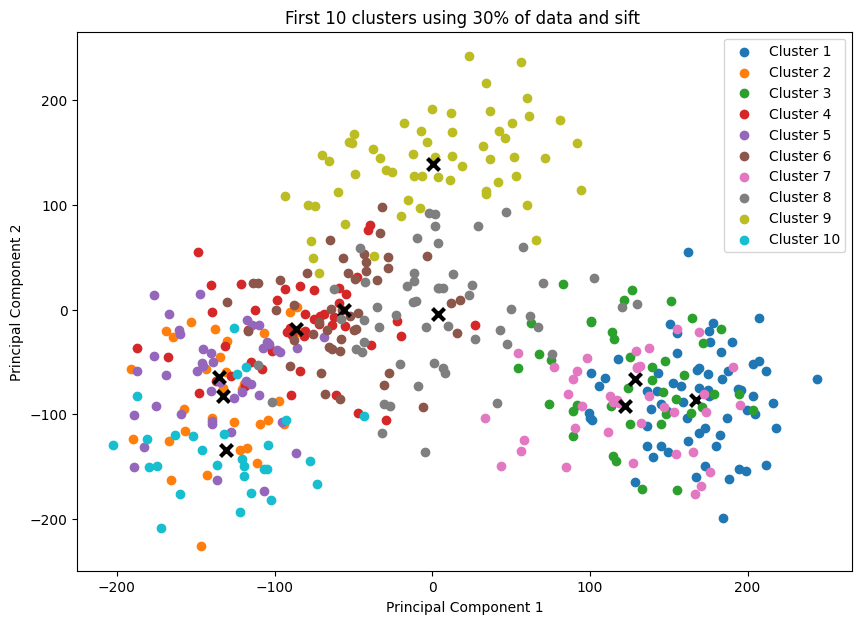

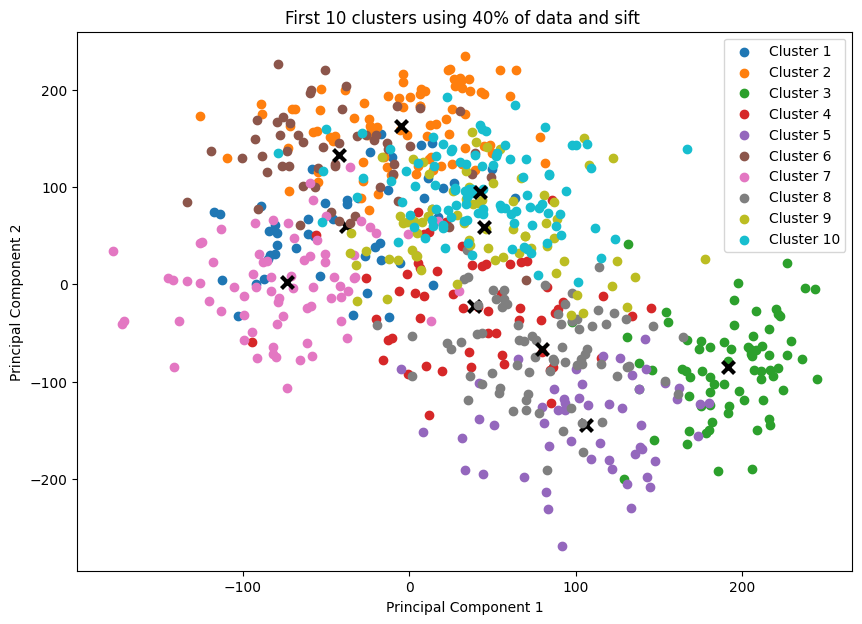

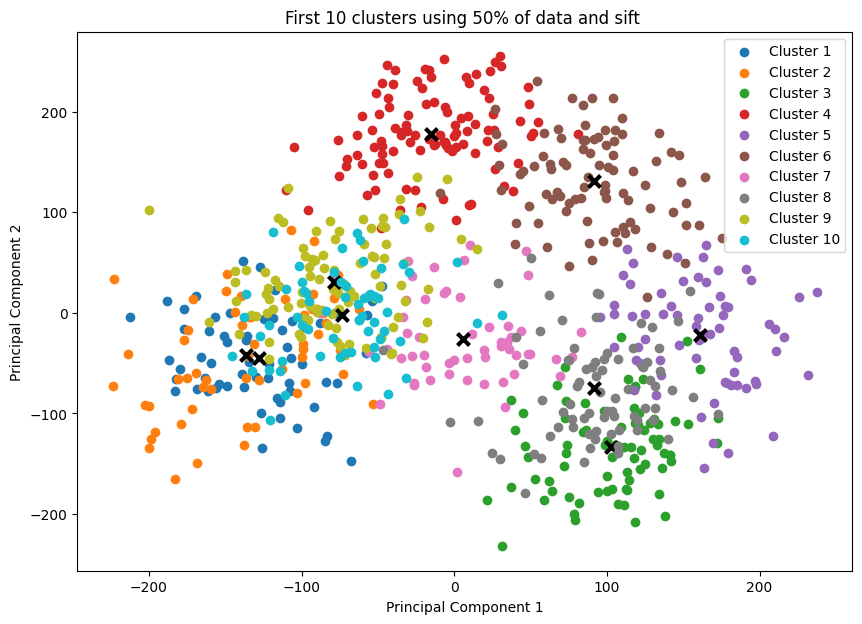

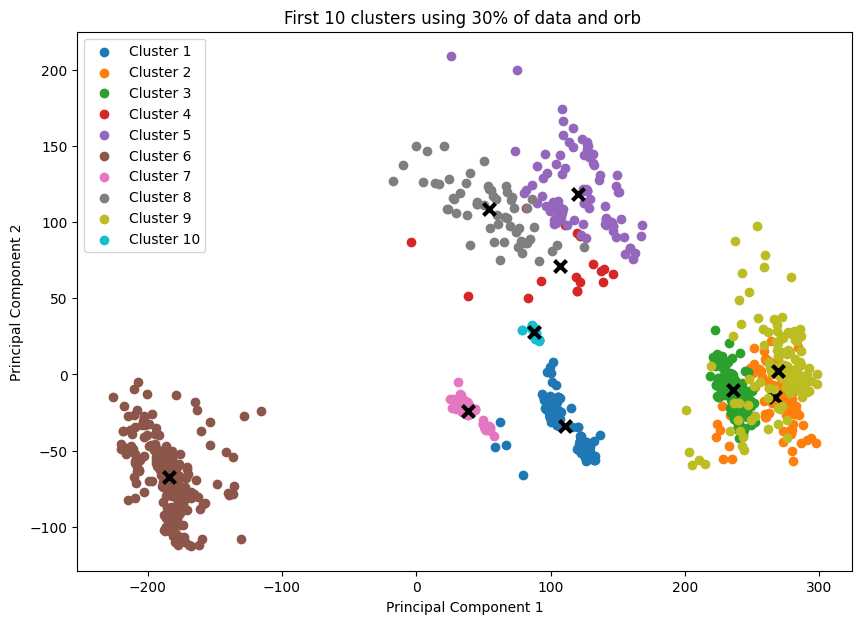

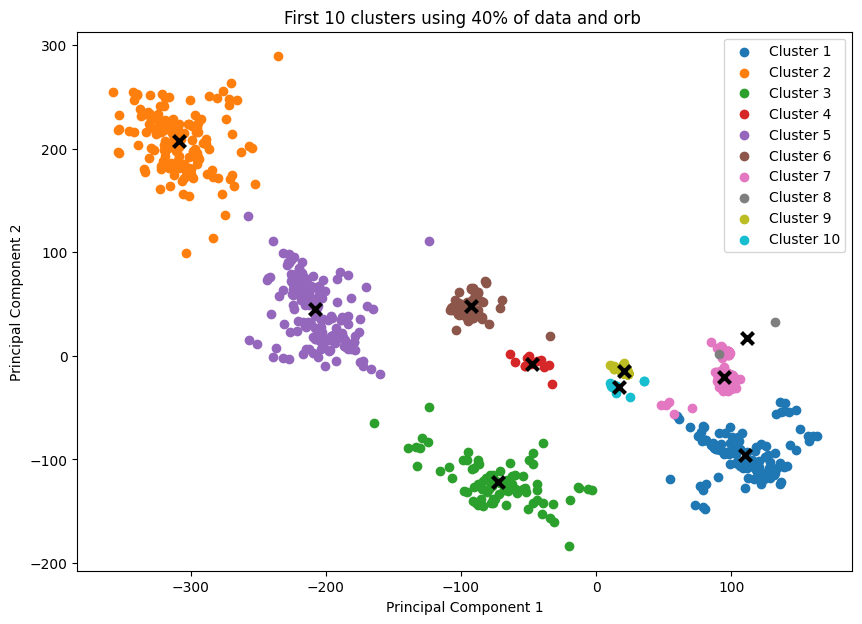

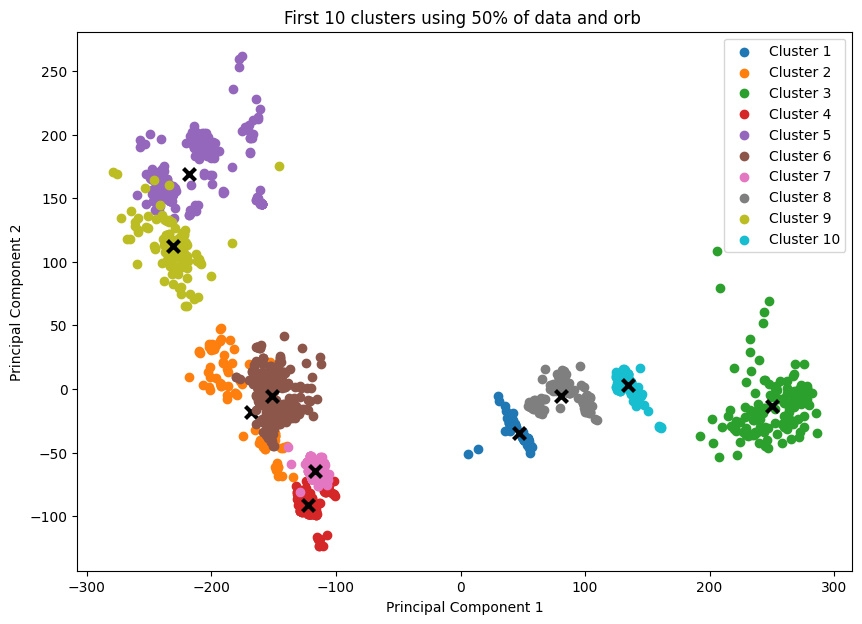

In [33]:
for i, method in enumerate(["sift", "orb"]):
    for j, frac in enumerate([0.3, 0.4, 0.5]):
        subset_img, subset_labels = get_subdata(frac, train_images, train_labels)

        _, descriptors = keypoints_and_descriptors(subset_img, method)
        subset_dp = [descriptor for descriptor in descriptors if descriptor is not None] # filter out empty descriptors
        subset_descriptors = np.concatenate(subset_dp, axis=0).astype(np.float32) # unique numpy array from list of descriptors

        kmeans = compute_kmeans(subset_descriptors)
        pca = compute_pca(subset_descriptors)

        centers = kmeans.centroids
        _, cluster_assignments = kmeans.index.search(subset_descriptors, 1)
        cluster_assignments = cluster_assignments.flatten()

        # reduce dimensions to 2
        red_centers = pca.transform(centers)
        red_descriptors = pca.transform(subset_descriptors)

        visualize_clusters(red_centers, red_descriptors, cluster_assignments, method, frac)

<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

In [34]:
def images_encoded(images, visual_words, method, num_of_visual_words=1000, scale=4):
    num_images = images.shape[0]
    dim = visual_words.shape[1]

    histograms = np.zeros((num_images, num_of_visual_words), dtype=np.float64)

    # nearest neighbour database
    index = faiss.IndexFlatL2(dim)
    index.add(visual_words)

    for i in range(num_images):
        image = images[i]
        denorm_image = denormalize_image(image, scale=scale)

        # find all descriptors of image and create numpy array of it
        _, descriptors = extract_features(denorm_image, method)
        if descriptors is not None:
            image_dp = [descriptor for descriptor in descriptors if descriptor is not None]
            image_dp = np.array(image_dp).astype(np.float32)
        else:
            continue

        # apply nearest neighbour
        _, indices = index.search(image_dp, 1)
        indices = indices.flatten()

        for j in indices:
            histograms[i, j] += 1

        histograms[i] /= np.sum(histograms[i])

    return histograms

def create_visual_words(images, method, num_of_visual_words=1000, scale=4):

    # standard filtering of descriptors (like done previously)
    _, descriptors = keypoints_and_descriptors(images, method, scale)
    filtered_descs = [descriptor for descriptor in descriptors if descriptor is not None]
    filtered_descs = np.concatenate(filtered_descs, axis=0).astype(np.float32)

    kmeans = compute_kmeans(filtered_descs, n_clusters=num_of_visual_words)
    visual_words = kmeans.centroids

    return visual_words

In [35]:
# encode 50% of the train images using both SIFT and ORB methods

set50_train_images, set50_train_labels = get_subdata(0.5, train_images, train_labels)

visual_words_sift50 = create_visual_words(set50_train_images, "sift")
visual_words_orb50 = create_visual_words(set50_train_images, "orb")

images_enc_sift50 = images_encoded(set50_train_images, visual_words_sift50, "sift")
images_enc_orb50 = images_encoded(set50_train_images, visual_words_orb50, "orb")

<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.

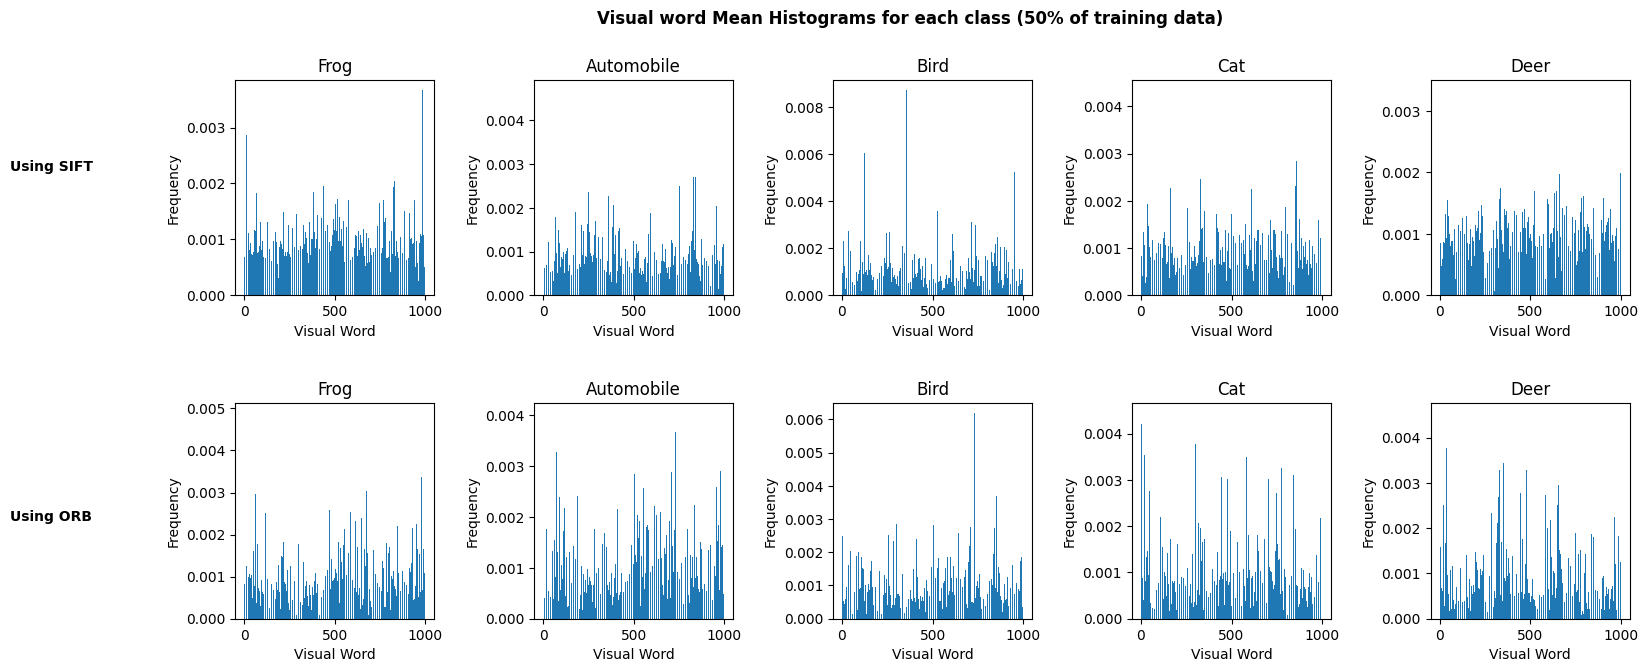

In [36]:
# using the visual words and image encodings previously found

fig, axes = plt.subplots(2, 5, figsize=(18, 7))

for i, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
    mask = (set50_train_labels == i).numpy()
    indices = np.where(mask == True)

    # extract images for label
    enc_img_sift = images_enc_sift50[indices]
    enc_img_orb = images_enc_orb50[indices]

    #calculate mean histogram
    mean_sift = np.mean(enc_img_sift, axis=0)
    mean_orb = np.mean(enc_img_orb, axis=0)

    axes[0, i].bar(np.arange(len(mean_sift)), mean_sift)
    axes[0, i].set_title(label)
    axes[0, i].set_xlabel("Visual Word")
    axes[0, i].set_ylabel("Frequency")

    axes[1, i].bar(np.arange(len(mean_orb)), mean_orb)
    axes[1, i].set_title(label)
    axes[1, i].set_xlabel("Visual Word")
    axes[1, i].set_ylabel("Frequency")

fig.suptitle("Visual word Mean Histograms for each class (50% of training data)", fontweight="bold")
fig.text(0, 0.75, "Using SIFT", fontweight="bold")
fig.text(0, 0.25, "Using ORB", fontweight="bold")
fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig(os.path.join("results", "mean_histograms_50perc_train.png"))

plt.show()

<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

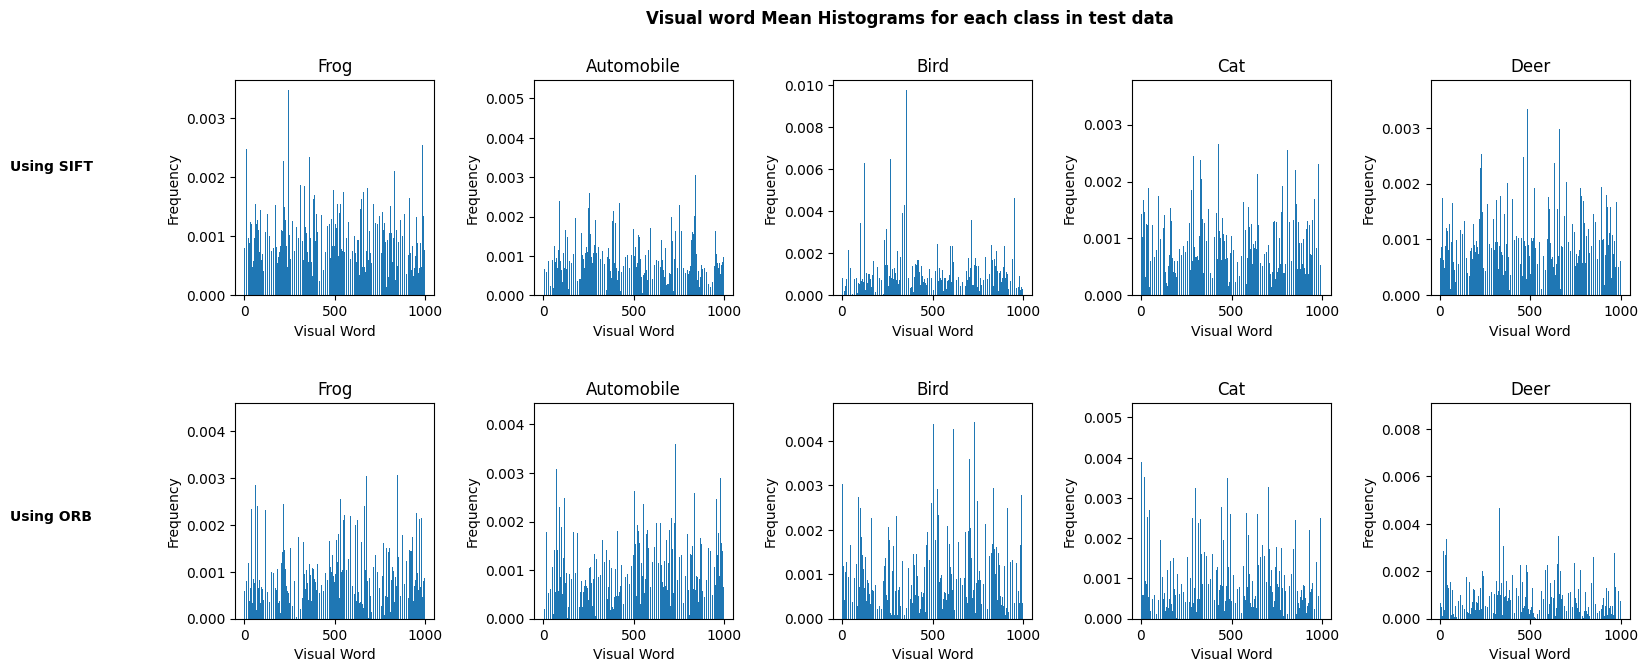

In [37]:
# same visual words as before, we encode the test image features using SIFT and ORB methods
enc_test_sift = images_encoded(test_images, visual_words_sift50, "sift")
enc_test_orb = images_encoded(test_images, visual_words_orb50, "orb")

# we plot similar mean histograms as before
fig, axes = plt.subplots(2, 5, figsize=(18, 7))

for i, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
    mask = (test_labels == i).numpy()
    indices = np.where(mask == True)

    # extract images for label
    enc_img_sift = enc_test_sift[indices]
    enc_img_orb = enc_test_orb[indices]

    #calculate mean histogram
    mean_sift = np.mean(enc_img_sift, axis=0)
    mean_orb = np.mean(enc_img_orb, axis=0)

    axes[0, i].bar(np.arange(len(mean_sift)), mean_sift)
    axes[0, i].set_title(label)
    axes[0, i].set_xlabel("Visual Word")
    axes[0, i].set_ylabel("Frequency")

    axes[1, i].bar(np.arange(len(mean_orb)), mean_orb)
    axes[1, i].set_title(label)
    axes[1, i].set_xlabel("Visual Word")
    axes[1, i].set_ylabel("Frequency")

fig.suptitle("Visual word Mean Histograms for each class in test data", fontweight="bold")
fig.text(0, 0.75, "Using SIFT", fontweight="bold")
fig.text(0, 0.25, "Using ORB", fontweight="bold")
fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig(os.path.join("results", "mean_histograms_test.png"))

plt.show()

<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [38]:
# function that returns desired percentage of data + the remaining part
def get_datasplits(frac, images, labels):

    total_n = images.shape[0]
    new_n = int(frac * total_n)
    images_set1 = images[:new_n]
    labels_set1 = labels[:new_n]

    images_set2 = images[new_n:]
    labels_set2 = labels[new_n:]

    return images_set1, labels_set1, images_set2, labels_set2

# split the data (first obtained set == same set as before)
set1_train_images, set1_train_labels, set2_train_images, set2_train_labels = get_datasplits(0.5, train_images, train_labels)

# encode remaining set of images using visual words
set2_img_enc_sift = images_encoded(set2_train_images, visual_words_sift50, "sift")
set2_img_enc_orb = images_encoded(set2_train_images, visual_words_orb50, "orb")

svm_sift = SVC(decision_function_shape="ovr")
svm_orb = SVC(decision_function_shape="ovr")

svm_sift.fit(set2_img_enc_sift, set2_train_labels)
svm_orb.fit(set2_img_enc_orb, set2_train_labels)

# accuracy report for training set
pred_svm_sift_train = svm_sift.predict(set2_img_enc_sift)
pred_svm_orb_train = svm_orb.predict(set2_img_enc_orb)
print("Accuracy report for SVM with SIFT features on second half of training set:")
print(classification_report(set2_train_labels, pred_svm_sift_train))
print()
print("Accuracy report for SVM with ORB features on second half of training set:")
print(classification_report(set2_train_labels, pred_svm_orb_train))
print()

# same for test set
pred_svm_sift_test = svm_sift.predict(enc_test_sift)
pred_svm_orb_test = svm_orb.predict(enc_test_orb)
print("Accuracy report for SVM with SIFT features on test data:")
print(classification_report(test_labels, pred_svm_sift_test))
print()
print("Accuracy report for SVM with ORB features on test data:")
print(classification_report(test_labels, pred_svm_orb_test))

Accuracy report for SVM with SIFT features on second half of training set:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       482
           1       0.86      0.98      0.92       540
           2       0.97      0.87      0.91       481
           3       0.99      0.89      0.94       515
           4       0.98      0.90      0.94       482

    accuracy                           0.92      2500
   macro avg       0.93      0.92      0.92      2500
weighted avg       0.93      0.92      0.92      2500


Accuracy report for SVM with ORB features on second half of training set:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       482
           1       0.64      0.96      0.76       540
           2       0.93      0.76      0.84       481
           3       0.89      0.80      0.84       515
           4       0.97      0.72      0.82       482

    accuracy                       

<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

In [39]:
def class_rankings(svm, encoded_images):

    classifcation_scores = svm.decision_function(encoded_images)
    
    num_classes = classifcation_scores.shape[1]

    rankings = []

    for class_i in range(num_classes):
        scores_class_i = classifcation_scores[:, class_i]
        ranking_class_i = scores_class_i.argsort()[::-1]
        rankings.append(ranking_class_i)

    rankings = np.array(rankings).T
    return rankings

def m_Avg_Prec(ranking, labels):

    num_images, num_classes = ranking.shape[0], ranking.shape[1]

    ap_per_class = []

    for class_c in range(num_classes):
        m_c = torch.count_nonzero(labels == class_c).item()
        ranking_class_c = ranking[:, class_c]

        current_count_correct = 0
        sum = 0

        for i in range(num_images):
            next_image_index = ranking_class_c[i]
            correct_label = labels[next_image_index]
            f = 0
            if correct_label == class_c:
                current_count_correct += 1
                f = current_count_correct
            sum += (f / (i + 1))

        average_precision_c = sum / m_c
        ap_per_class.append(average_precision_c)

    ap_per_class = np.array(ap_per_class)
    map = np.mean(ap_per_class)

    return ap_per_class, map

In [40]:
rankings_sift = class_rankings(svm_sift, enc_test_sift)
rankings_orb = class_rankings(svm_orb, enc_test_orb)

avg_p_sift, map_sift = m_Avg_Prec(rankings_sift, test_labels)
avg_p_orb, map_orb = m_Avg_Prec(rankings_orb, test_labels)

print("Results using SIFT features: ")
print("----------------------------")
for i, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
    print(f"Average Precision for class {label}: {avg_p_sift[i]}")
print(f"Mean Average Precision (mAP): {map_sift}")
print()

print("Results using ORB features: ")
print("----------------------------")
for i, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
    print(f"Average Precision for class {label}: {avg_p_orb[i]}")
print(f"Mean Average Precision (mAP): {map_orb}")

Results using SIFT features: 
----------------------------
Average Precision for class Frog: 0.5027386151955808
Average Precision for class Automobile: 0.5692753675616098
Average Precision for class Bird: 0.4756664952999501
Average Precision for class Cat: 0.28771967111572033
Average Precision for class Deer: 0.3772215426755359
Mean Average Precision (mAP): 0.4425243383696794

Results using ORB features: 
----------------------------
Average Precision for class Frog: 0.43994789332075784
Average Precision for class Automobile: 0.5136402007282519
Average Precision for class Bird: 0.345329599669601
Average Precision for class Cat: 0.26144659985408036
Average Precision for class Deer: 0.29474619650447115
Mean Average Precision (mAP): 0.3710220980154325


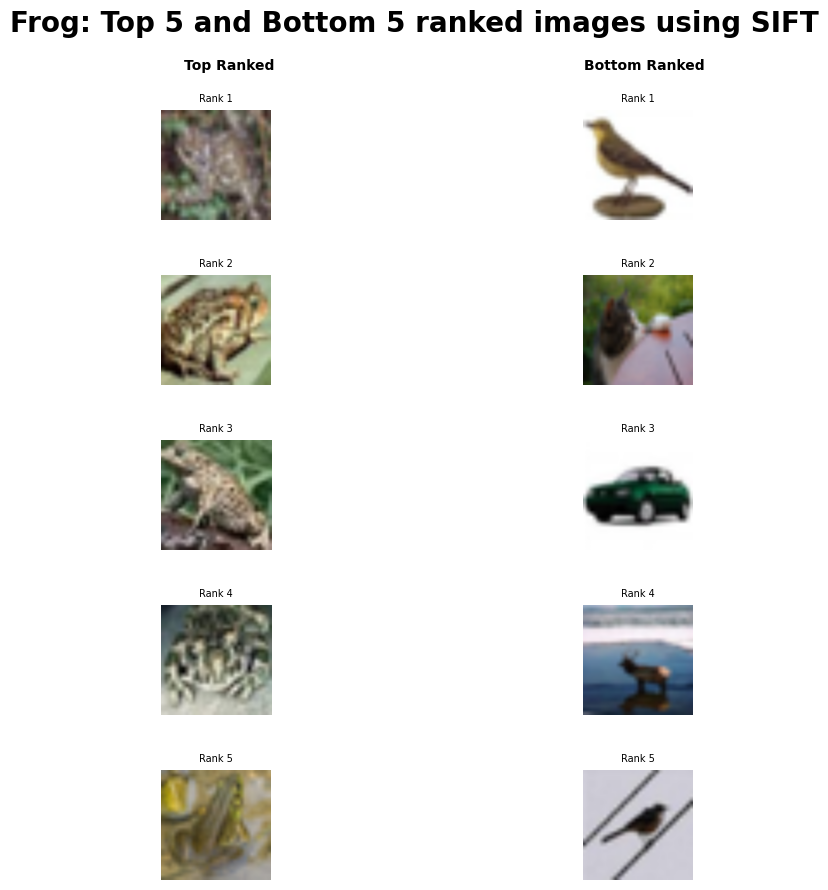

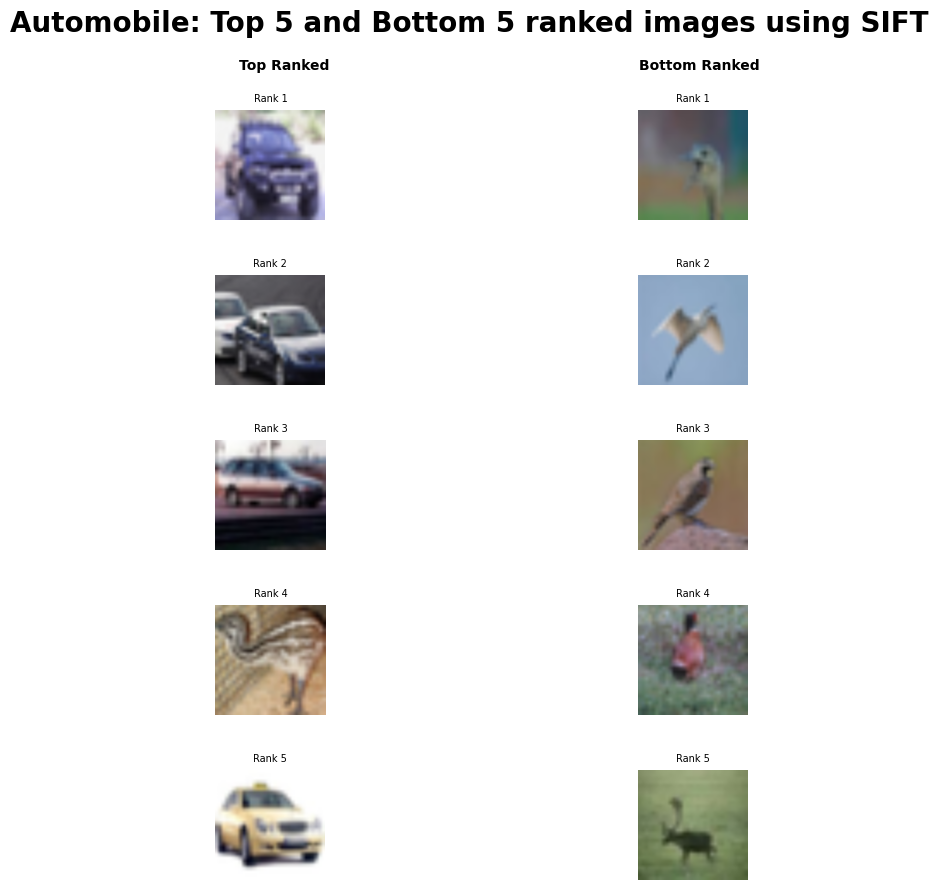

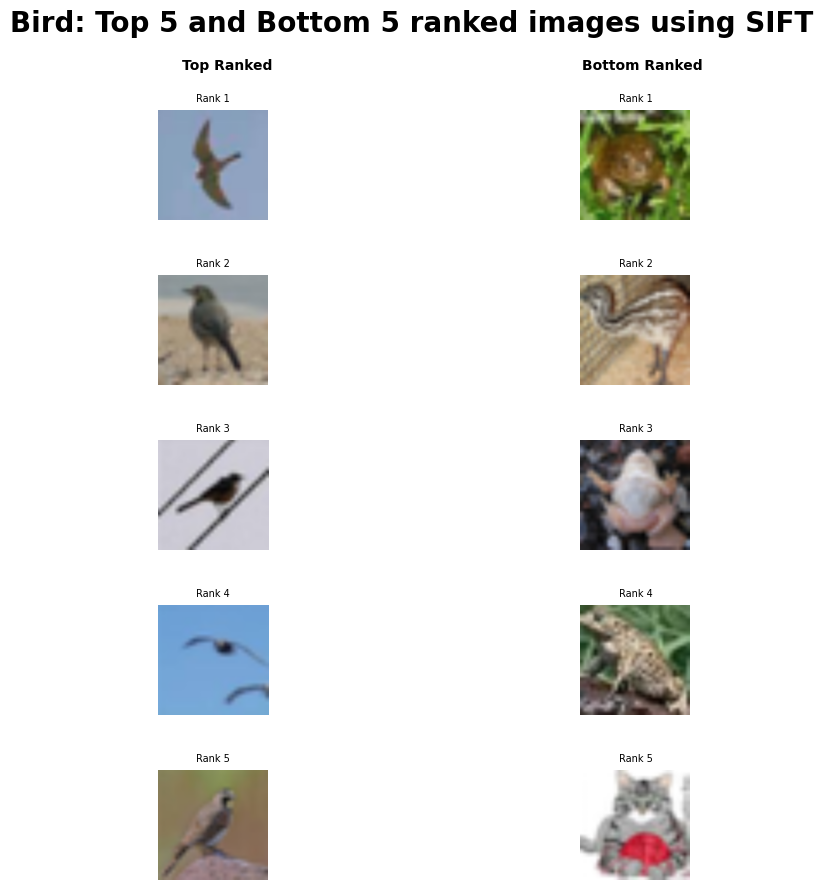

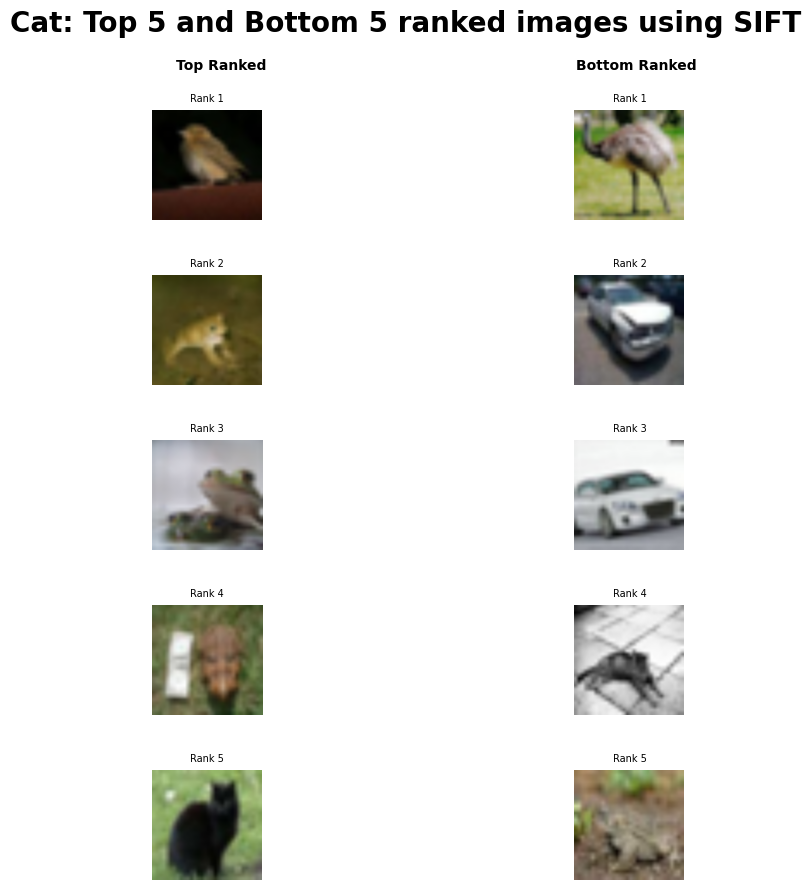

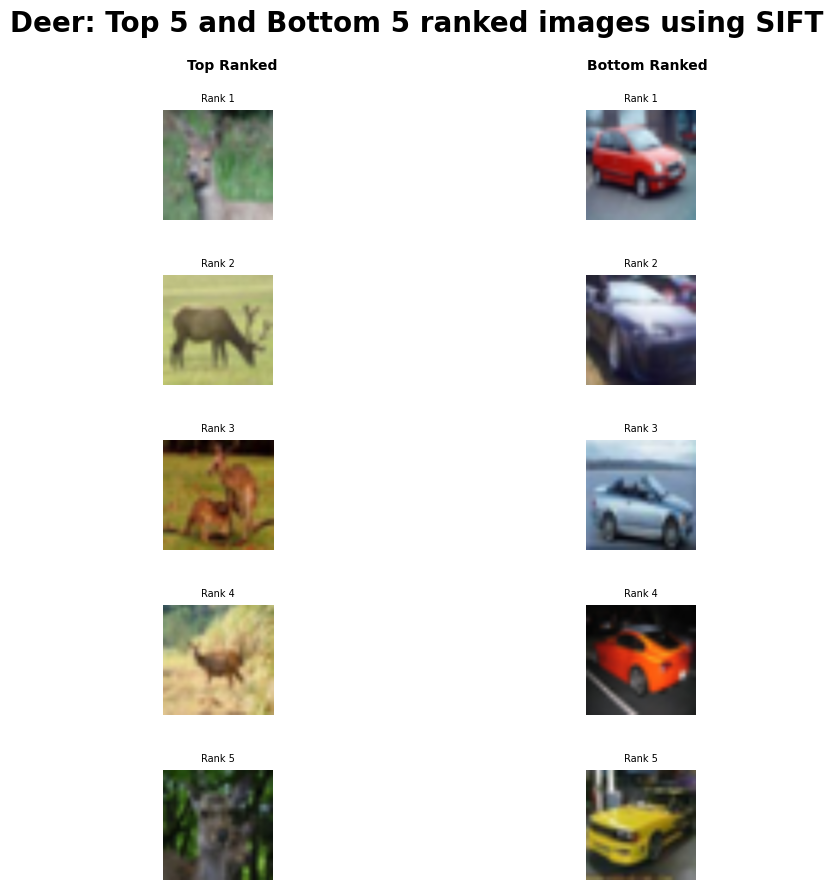

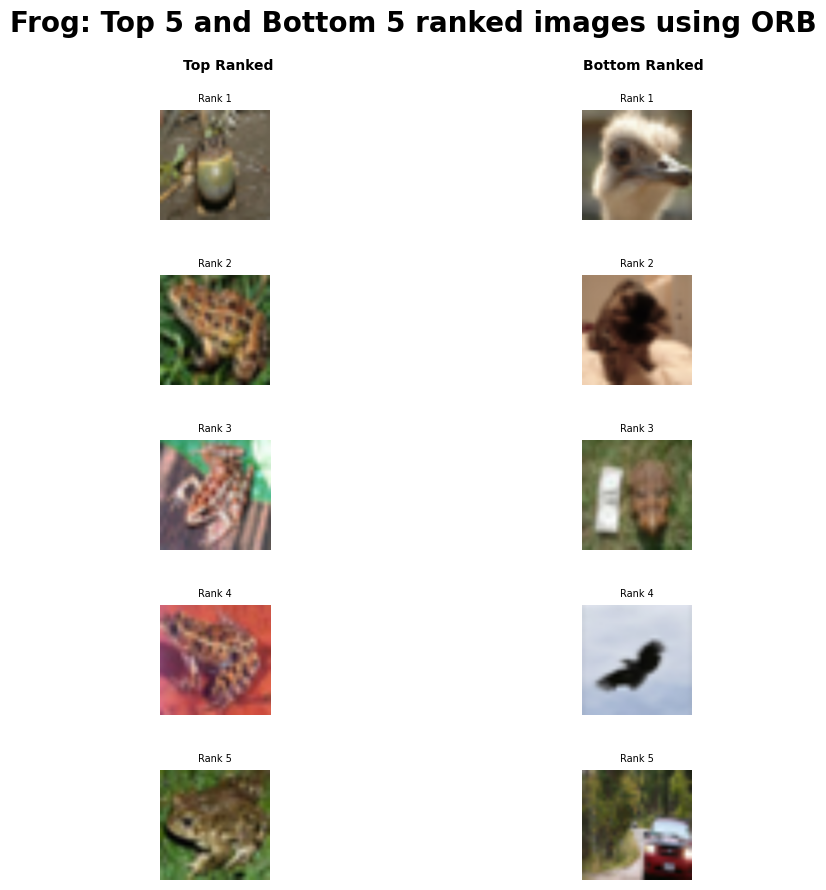

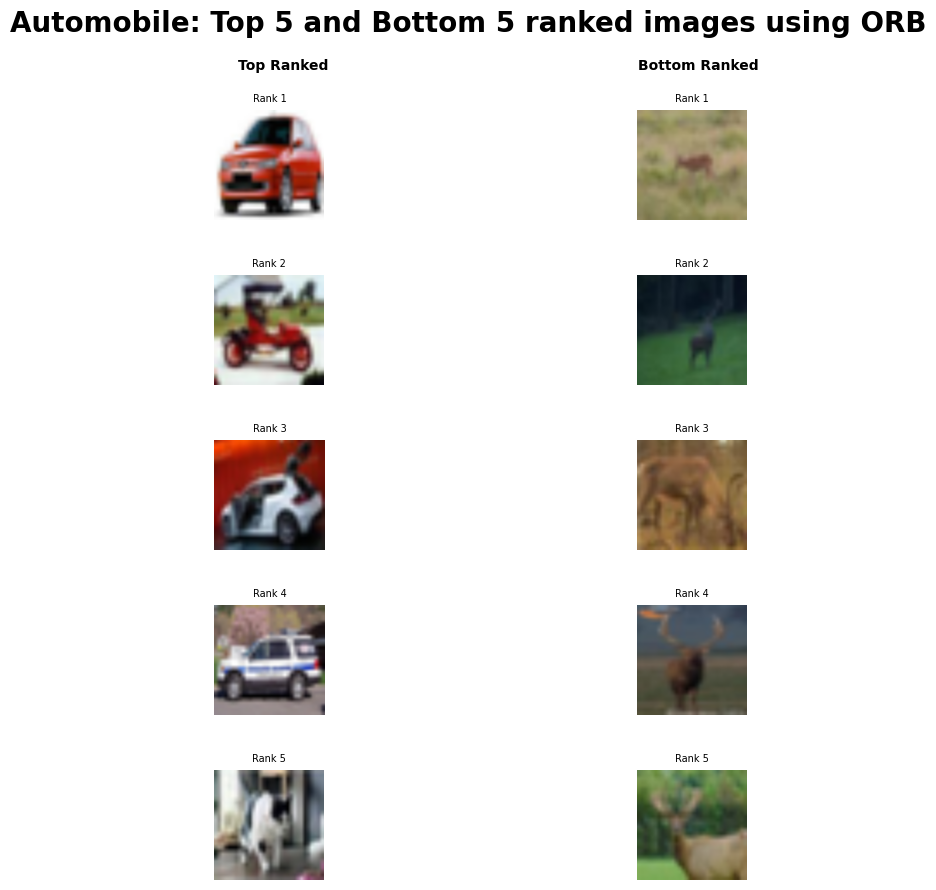

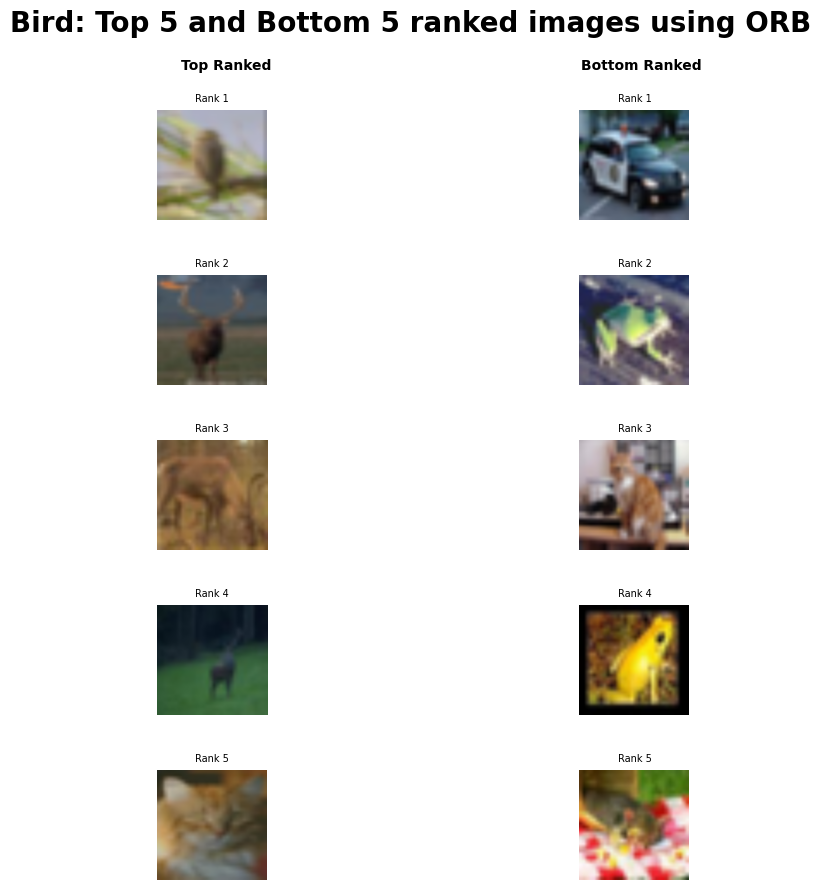

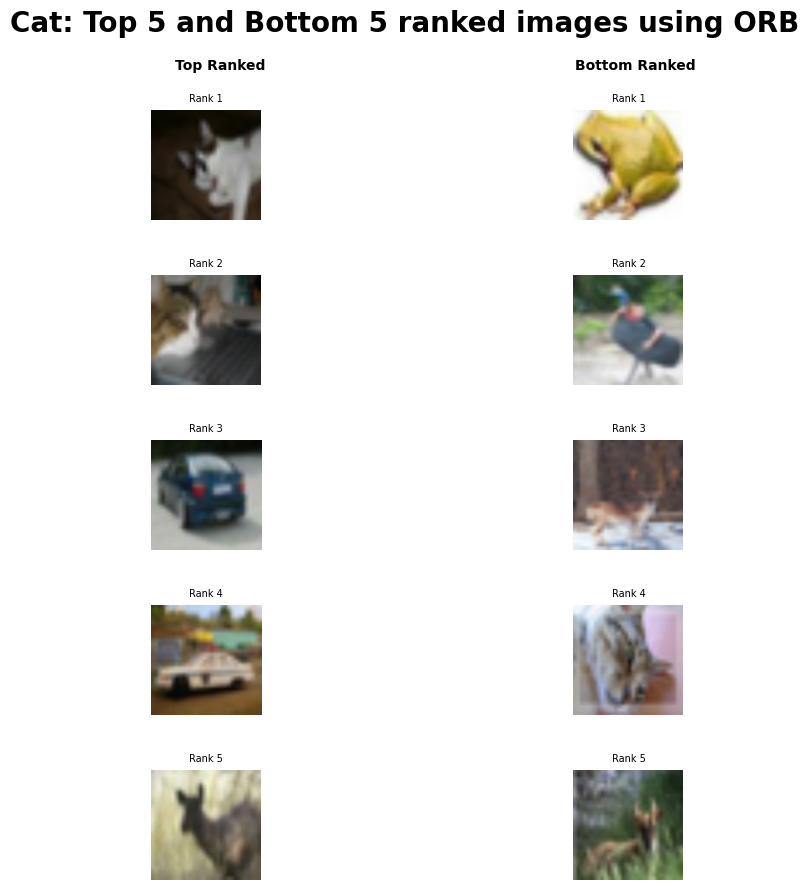

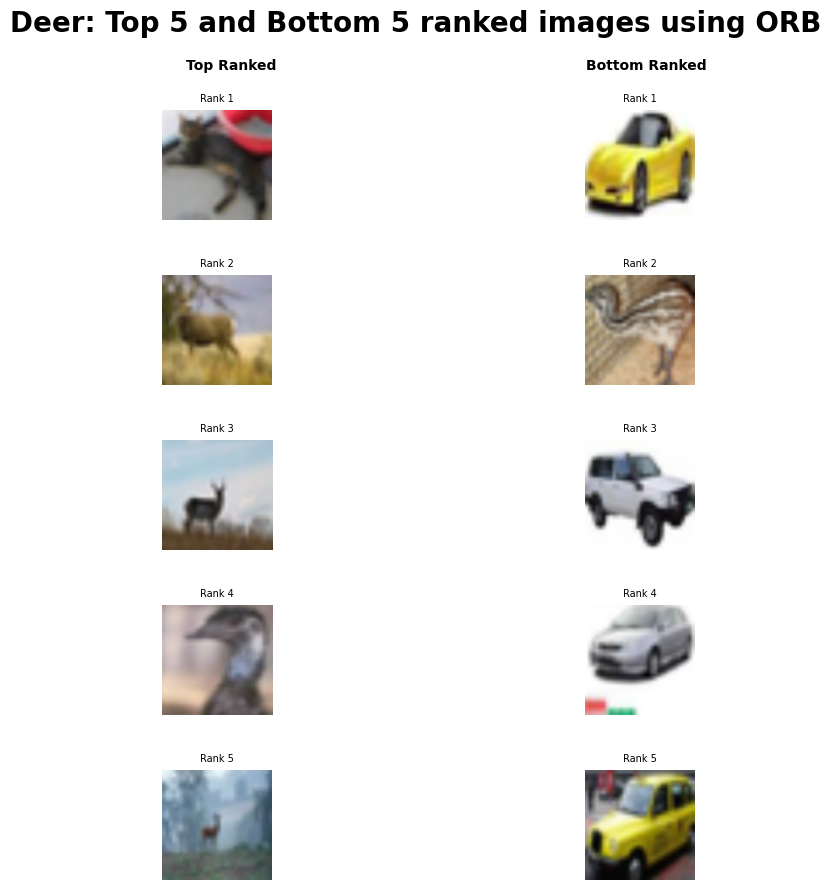

In [41]:
def visualize_top_and_bottom(rankings, images, method, k=5):

    for c, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
        ranking_class_c = rankings[:, c]

        fig, axes = plt.subplots(k, 2, figsize=(10, 10))
        fig.suptitle(f"{label}: Top {k} and Bottom {k} ranked images using {method}", fontweight="bold", fontsize=20)
        fig.text(0.27, 0.92, "Top Ranked", fontweight="bold")
        fig.text(0.67, 0.92, "Bottom Ranked", fontweight="bold")

        for i in range(k):
            top_ranked_index = ranking_class_c[i]
            bottom_ranked_index = ranking_class_c[(ranking_class_c.shape[0] - (i + 1))]

            top_image = images[top_ranked_index]
            bottom_image = images[bottom_ranked_index]

            top_image = denormalize_image(top_image)
            bottom_image = denormalize_image(bottom_image)

            axes[i, 0].imshow(top_image)
            axes[i, 0].axis("off")
            axes[i, 0].set_title(f"Rank {i + 1}", fontsize=7)

            axes[k - (i + 1), 1].imshow(bottom_image)
            axes[k - (i + 1), 1].axis("off")
            axes[k - (i + 1), 1].set_title(f"Rank {k - i}", fontsize=7)

        fig.subplots_adjust(hspace=0.5)

        plt.savefig(os.path.join("results", "rankings", f"{label}_top_bottom_{method}.png"))

        plt.show()

visualize_top_and_bottom(rankings_sift, test_images, "SIFT", k=5)
visualize_top_and_bottom(rankings_orb, test_images, "ORB", k=5)

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

Found new intermediate better model, with mAP 0.3724723882993396 and parameters: {'method': 'sift', 'num_of_visual_words': 500, 'scale': 4, 'svm_c': 0.1, 'svm_gamma': 'scale', 'svm_kernel': 'rbf', 'train_frac': 0.4}
Found new intermediate better model, with mAP 0.45366445297607366 and parameters: {'method': 'sift', 'num_of_visual_words': 500, 'scale': 4, 'svm_c': 1, 'svm_gamma': 'scale', 'svm_kernel': 'rbf', 'train_frac': 0.4}
Found new intermediate better model, with mAP 0.45699563227676565 and parameters: {'method': 'sift', 'num_of_visual_words': 500, 'scale': 5, 'svm_c': 1, 'svm_gamma': 'scale', 'svm_kernel': 'rbf', 'train_frac': 0.4}
Found new intermediate better model, with mAP 0.46283782281542757 and parameters: {'method': 'sift', 'num_of_visual_words': 500, 'scale': 5, 'svm_c': 1, 'svm_gamma': 'scale', 'svm_kernel': 'rbf', 'train_frac': 0.5}
Found new intermediate better model, with mAP 0.47009804237854674 and parameters: {'method': 'sift', 'num_of_visual_words': 1000, 'scale': 

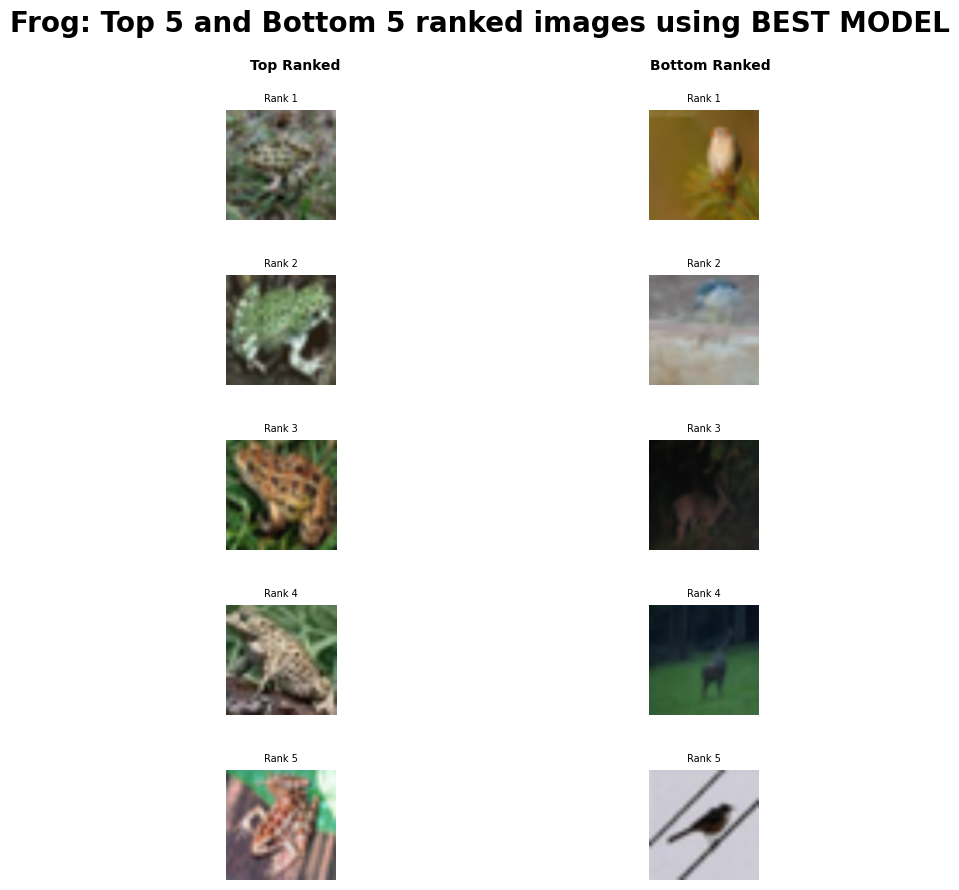

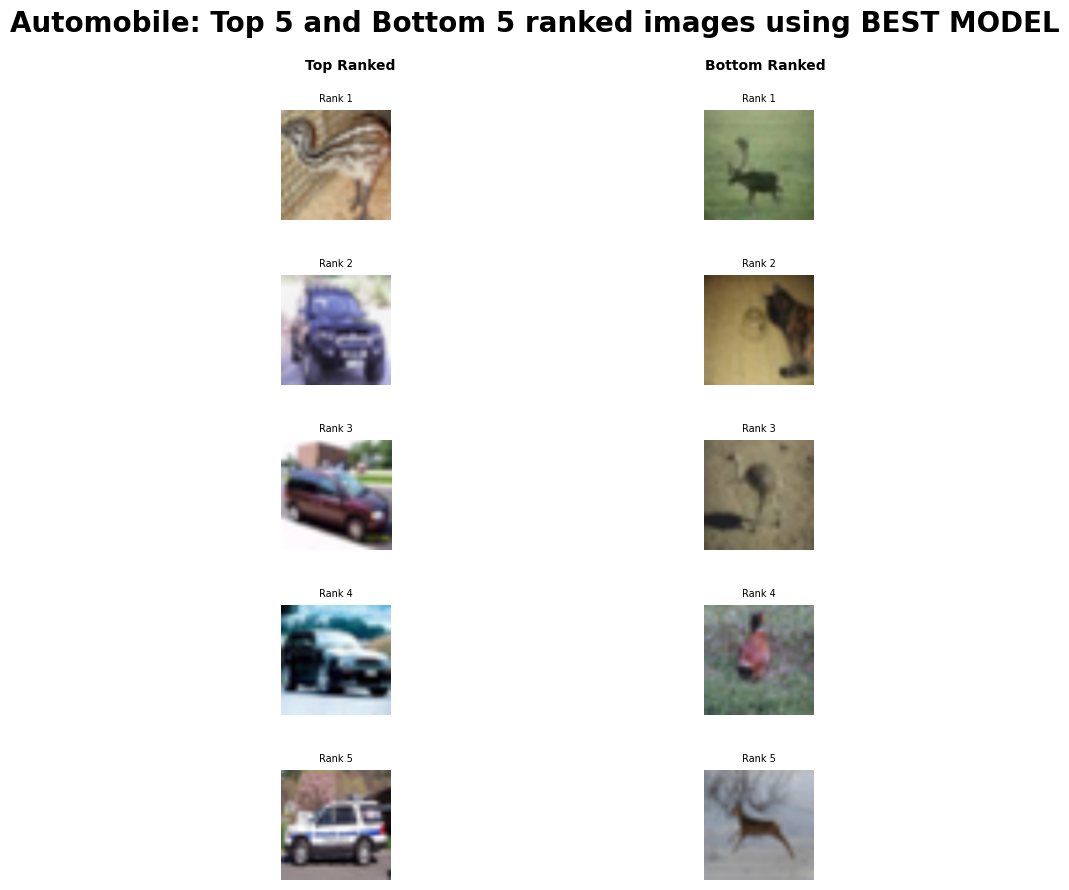

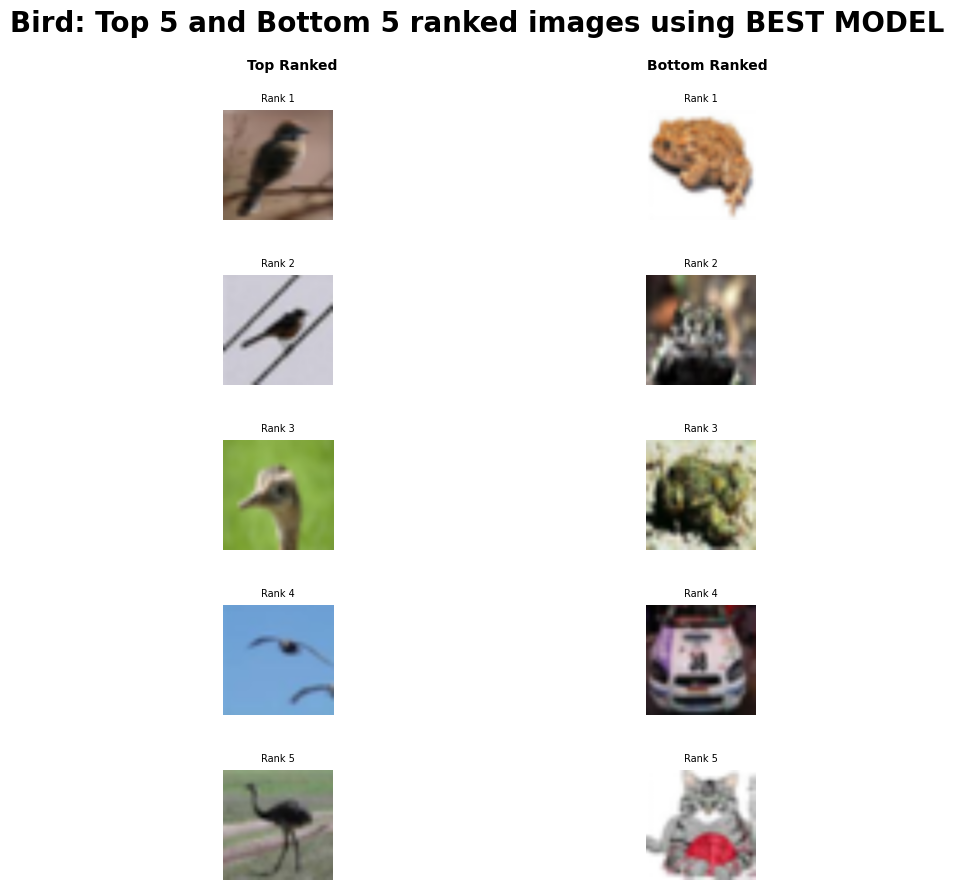

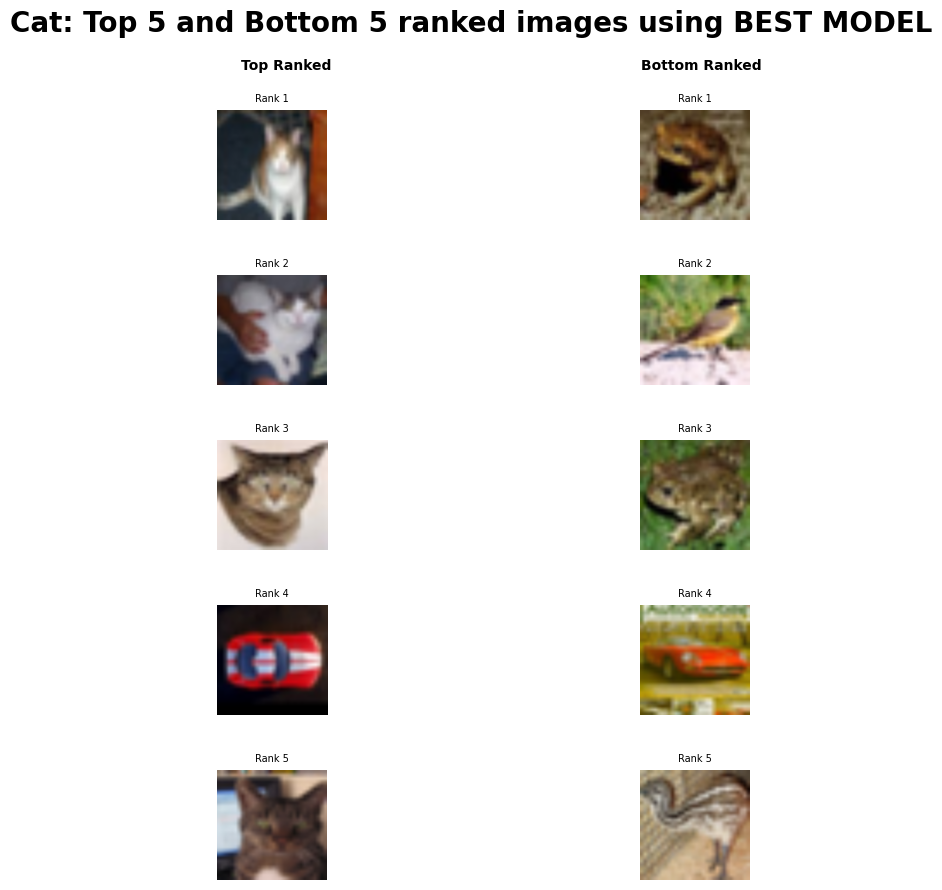

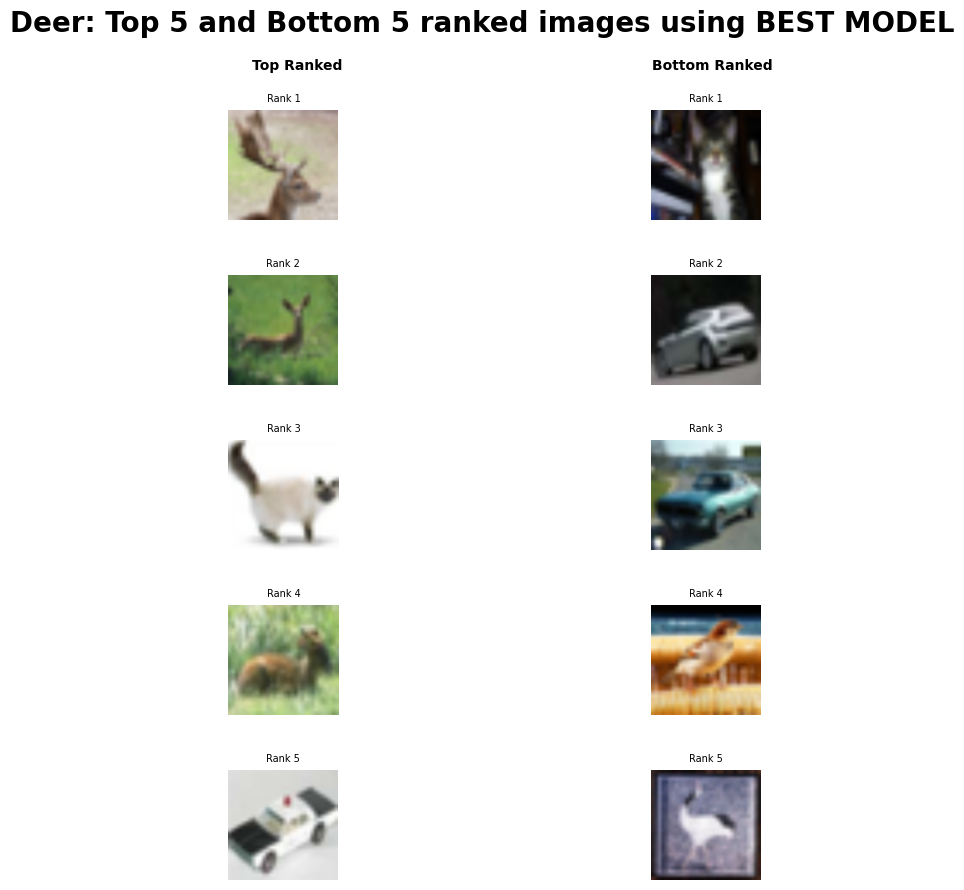

In [45]:

parameter_grid = {
    "num_of_visual_words": [500, 1000], #[500, 1000, 1500]
    "train_frac": [0.4, 0.5], #[0.3, 0.4, 0.5]
    "svm_kernel": ["rbf"], #["linear", "rbf", "sigmoid"]
    "svm_c": [0.1, 1], #[0.1, 1, 10]
    "svm_gamma": ["scale"], #["scale", 0.01, 0.001]
    "method": ["sift"], #["sift", "orb"]
    "scale": [4, 5] #[3,4,5]
}

grid = ParameterGrid(parameter_grid)

best_mAP = 0
best_params = None
best_ap = 0
best_svm = None
best_rankings = None
best_test_enc = None
best_test_images = None
best_test_labels = None


for params in grid:

  images_set1, labels_set1, images_set2, labels_set2 = get_datasplits(params["train_frac"], train_images, train_labels)

  visual_words = create_visual_words(images_set1, params["method"], params["num_of_visual_words"], scale=params["scale"])

  images_set2_enc = images_encoded(images_set2, visual_words, params["method"], params["num_of_visual_words"], scale=params["scale"])

  svm = SVC(decision_function_shape="ovr", kernel=params["svm_kernel"], C=params["svm_c"], gamma=params["svm_gamma"])

  svm.fit(images_set2_enc, labels_set2)

  test_images_enc = images_encoded(test_images, visual_words, params["method"], params["num_of_visual_words"], scale=params["scale"])

  rankings = class_rankings(svm, test_images_enc)

  AP, mAP = m_Avg_Prec(rankings, test_labels)

  if mAP > best_mAP:
    best_mAP = mAP
    best_params = params
    best_ap = AP
    best_svm = svm
    best_rankings = rankings
    best_test_enc = test_images_enc
    best_test_images = test_images
    best_test_labels = test_labels
    print(f"Found new intermediate better model, with mAP {best_mAP} and parameters: {best_params}")


print()
print("BEST POSSIBLE MODEL")
print(f"Best parameters: {best_params}")
for i, label in enumerate(["Frog", "Automobile", "Bird", "Cat", "Deer"]):
    print(f"Average Precision for class {label}: {best_ap[i]}")
print(f"Mean Average Precision (mAP): {best_mAP}")
print()

pred_best_svm = best_svm.predict(best_test_enc)
print("Accuracy report for the best SVM on test data:")
print(classification_report(best_test_labels, pred_best_svm))

visualize_top_and_bottom(best_rankings, best_test_images, "BEST MODEL", k=5)



<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [14]:
# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations (resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Clip uses 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=16, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=16, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([16, 224, 224, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([16, 224, 224, 3])
Filtered test labels: torch.Size([1000])


Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text.

In [3]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [01:13<00:00, 4.80MiB/s]


To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [17]:
from tqdm import tqdm
image_features_list = []
target_labels_list = []

# Set the model to evaluation mode
model.eval()

# Extract features
with torch.no_grad():  # Disable gradient computation
    for images, batch_labels in tqdm(train_data_loader, desc="Extracting Features"):

        # Move images to the appropriate device
        images = images.to(device)
        
        # Encode images to extract features
        features = model.encode_image(images)
        
        # Reshape if needed and convert to CPU
        features = features.cpu()

        # Append features and labels
        image_features_list.append(features)
        target_labels_list.append(batch_labels)

Extracting Features: 100%|██████████| 313/313 [06:59<00:00,  1.34s/it]


In [18]:
# Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
stacked_image_features = torch.cat(image_features_list)
stacked_target_labels = torch.cat(target_labels_list)

To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', verbose=2)
grid_search.fit(stacked_image_features, stacked_target_labels)

# Best parameters from grid search
print(f"Best parameters: {grid_search.best_params_}")

# Train the classifier with the best found parameters
best_svm = grid_search.best_estimator_

# Predict on the training set
predictions = best_svm.predict(stacked_image_features)

# Print classification report and accuracy
print(classification_report(stacked_target_labels, predictions))
print(f"Accuracy: {accuracy_score(stacked_target_labels, predictions)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   3.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ...................C=0.1, gamma=auto, k

To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [23]:
import torch
from tqdm import tqdm

test_image_features = []
test_target_labels = []

# Loop through the test DataLoader
for images, labels in tqdm(test_data_loader):
    # Move images to the appropriate device (CPU/GPU)
    images = images.to(device) 

    # Disable gradient computation for inference
    with torch.no_grad():
        # Encode the images to get the visual features
        features = model.encode_image(images)

    # Append features and labels to the respective lists
    test_image_features.append(features.cpu()) 
    test_target_labels.append(labels.cpu())

# Stack the lists into tensors
test_image_features = torch.cat(test_image_features)
test_labels = torch.cat(test_target_labels)

# Make predictions on the test set
test_predictions = best_svm.predict(test_image_features)

100%|██████████| 63/63 [01:30<00:00,  1.43s/it]


To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [24]:
# Create a classification report
report = classification_report(test_labels, test_predictions)

# Print the classification report
print("Classification Report:\n", report)

# Calculate and print accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.2f}")

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       200
           2       0.96      0.93      0.94       200
           3       0.94      0.96      0.95       200
           4       0.95      0.96      0.96       200
           6       0.95      0.94      0.94       200

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Test Accuracy: 0.96


<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
| David Van Batenburg | 25% | 25% | 25% |
| Samuele Punzo | 25% | 25% | 25% |
| Edoardo Vergnano | 25% | 25% | 25% |
| Seyedeh Zahra Ahmadi | 25% | 25% | 25% |

### - End of Notebook -